# PRUEBAS RENDIMIENTO DEEPLABv3

## Configuración Entrenamientos

In [2]:
import os
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

from google.colab import files, drive

In [3]:
# Dataset personalizado
class ImageSegmentationDataset(Dataset):
    def __init__(self, img_dir, mask_dir, images, masks, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.images = images
        self.masks = masks
        self.transform = transform
        assert len(self.images) == len(self.masks)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        # Redimensionar a 512x512
        image = image.resize((512, 512))
        mask = mask.resize((512, 512))

        # Convertir a numpy y dividir por 255
        image = np.array(image) / 255.0
        mask = np.array(mask) / 255.0

        if self.transform:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        # Convertir a tensores nuevamente
        image = torch.from_numpy(image).float().permute(2, 0, 1)
        mask = torch.from_numpy(mask).unsqueeze(0).float()

        return image, mask

In [4]:
# Aumentación de datos
augmentation_transforms = A.Compose([
    A.RandomBrightnessContrast(p=0.5),
    A.Rotate(limit=360, p=0.5),
    A.GaussNoise(p=0.3),
    A.Resize(512, 512),
    # A.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0), max_pixel_value=255.0, p=1.0),
    ToTensorV2()
])

## Entrenamiento INRIA

In [ ]:
# Establezco una ruta absoluta a un directorio existente de mi Google Drive
# ROOT_DIR = "/content/drive/MyDrive/TFM/dataset/"
DRIVE_DIR = "/content/drive/MyDrive/TFM/dataset/"
# AUX_DIR = "/content/drive/MyDrive/TFM/auxiliar"

AUX_DIR = "/content"
ROOT_DIR = "/content/dataset"

# Conectamos con nuestro Google Drive
drive.mount('/content/drive')

IMAGES_DIR = os.path.join(ROOT_DIR, 'Processed Images INRIA')
MASKS_DIR = os.path.join(ROOT_DIR, 'Processed Masks INRIA')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Descarga del dataset
import shutil

# Copiar todo el contenido de la carpeta de Drive a la carpeta local
shutil.copytree(os.path.join(DRIVE_DIR, "Processed Images INRIA"), IMAGES_DIR)
shutil.copytree(os.path.join(DRIVE_DIR, "Processed Masks INRIA"), MASKS_DIR)

'/content/dataset/Processed Masks INRIA'

In [ ]:
# División de los datos en entrenamiento, validación y prueba
images = sorted(os.listdir(IMAGES_DIR))
masks = sorted(os.listdir(MASKS_DIR))
train_images, test_images, train_masks, test_masks = train_test_split(images, masks, test_size=0.2, random_state=42)
train_images, val_images, train_masks, val_masks = train_test_split(train_images, train_masks, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

# Dataset y DataLoader
train_dataset = ImageSegmentationDataset(img_dir=IMAGES_DIR, mask_dir=MASKS_DIR, images=train_images, masks=train_masks, transform=None) #transform=augmentation_transforms)
val_dataset = ImageSegmentationDataset(img_dir=IMAGES_DIR, mask_dir=MASKS_DIR, images=val_images, masks=val_masks, transform=None) #transform=augmentation_transforms)
test_dataset = ImageSegmentationDataset(img_dir=IMAGES_DIR, mask_dir=MASKS_DIR, images=test_images, masks=test_masks, transform=None) #transform=augmentation_transforms)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=0)


In [ ]:
sample_img, sample_mask = train_dataset[0]
print(sample_img.shape)
print(sample_mask.shape)

torch.Size([3, 512, 512])
torch.Size([1, 512, 512])


In [ ]:
sample_batch = next(iter(train_loader))
images_batch, masks_batch = sample_batch
print(images_batch.shape)
print(masks_batch.shape)

torch.Size([4, 3, 512, 512])
torch.Size([4, 1, 512, 512])


In [ ]:
# Modelo
model = models.segmentation.deeplabv3_resnet101(pretrained=True, progress=True)
model.classifier[4] = nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))

# Loss y optimizador
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [ ]:
# Entrenamiento con validación
num_epochs = 8
best_loss = float("inf")

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)["out"]
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Validación
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)["out"]
            loss = criterion(outputs, masks)
            val_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}")

    # Guardar el mejor modelo
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_val_loss,
        }, os.path.join(AUX_DIR, f'best_model_DeepLabV3Plus_1_{epoch}.pth'))

print("Entrenamiento finalizado.")

Epoch 1/8, Train Loss: 0.2470223116874695, Validation Loss: 0.1607360248102082
Epoch 2/8, Train Loss: 0.1473572303685877, Validation Loss: 0.13823236382669873
Epoch 3/8, Train Loss: 0.1318225764952324, Validation Loss: 0.13335301323069468
Epoch 4/8, Train Loss: 0.11749156146137803, Validation Loss: 0.12459480106002754
Epoch 5/8, Train Loss: 0.11485079550080829, Validation Loss: 0.12687058959570197
Epoch 6/8, Train Loss: 0.10636181048497005, Validation Loss: 0.12507878250545926
Epoch 7/8, Train Loss: 0.09874180088992472, Validation Loss: 0.12569252179728613
Epoch 8/8, Train Loss: 0.09156436877946059, Validation Loss: 0.12487600281834603
Entrenamiento finalizado.


## Evaluación - dataset INRIA

In [ ]:
from sklearn.metrics import f1_score, accuracy_score, jaccard_score

In [ ]:
# Establezco una ruta absoluta a un directorio existente de mi Google Drive
ROOT_DIR = "/content/drive/MyDrive/TFM/dataset/"
AUX_DIR = "/content/drive/MyDrive/TFM/auxiliar"

# Conectamos con nuestro Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 1. Carga los pesos del modelo
CHECKPOINT_PATH = os.path.join(AUX_DIR, 'best_model_DeepLabV3Plus_1_3.pth') # Actualiza con el nombre del archivo correcto
checkpoint = torch.load(CHECKPOINT_PATH)
model.load_state_dict(checkpoint['model_state_dict'])

# 2. Coloca el modelo en modo de evaluación
model.eval()

def calculate_metrics(model, criterion, test_loader, device):
    total_accuracy = 0
    total_f1 = 0
    total_iou = 0
    test_loss = 0
    total_samples = 0

    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)

            # Obtiene las predicciones del modelo
            outputs = model(images)["out"]

            # Calcula la pérdida
            loss = criterion(outputs, masks)
            test_loss += loss.item()

            # Obtiene las etiquetas binarias predichas (0 o 1)
            preds = torch.sigmoid(outputs).data.cpu().numpy() > 0.5
            true_labels = masks.data.cpu().numpy() > 0.5

            # Actualizar las métricas para este batch
            total_accuracy += accuracy_score(true_labels.flatten(), preds.flatten())
            total_f1 += f1_score(true_labels.flatten(), preds.flatten())
            total_iou += jaccard_score(true_labels.flatten(), preds.flatten())
            total_samples += 1

    # Calcular métricas promedio
    avg_test_loss = test_loss / total_samples
    avg_accuracy = total_accuracy / total_samples
    avg_f1 = total_f1 / total_samples
    avg_iou = total_iou / total_samples

    return avg_test_loss, avg_accuracy, avg_f1, avg_iou

# Ejemplo de uso
avg_test_loss, acc, f1, iou = calculate_metrics(model, criterion, test_loader, device)
print(f"Average Test Loss: {avg_test_loss}")
print(f"Accuracy: {acc}")
print(f"F1 Score: {f1}")
print(f"IoU (Jaccard Score): {iou}")


Average Test Loss: 0.12457748923657669
Accuracy: 0.9515579689873589
F1 Score: 0.8396381000145476
IoU (Jaccard Score): 0.7271778584001464


### Ejemplo 1

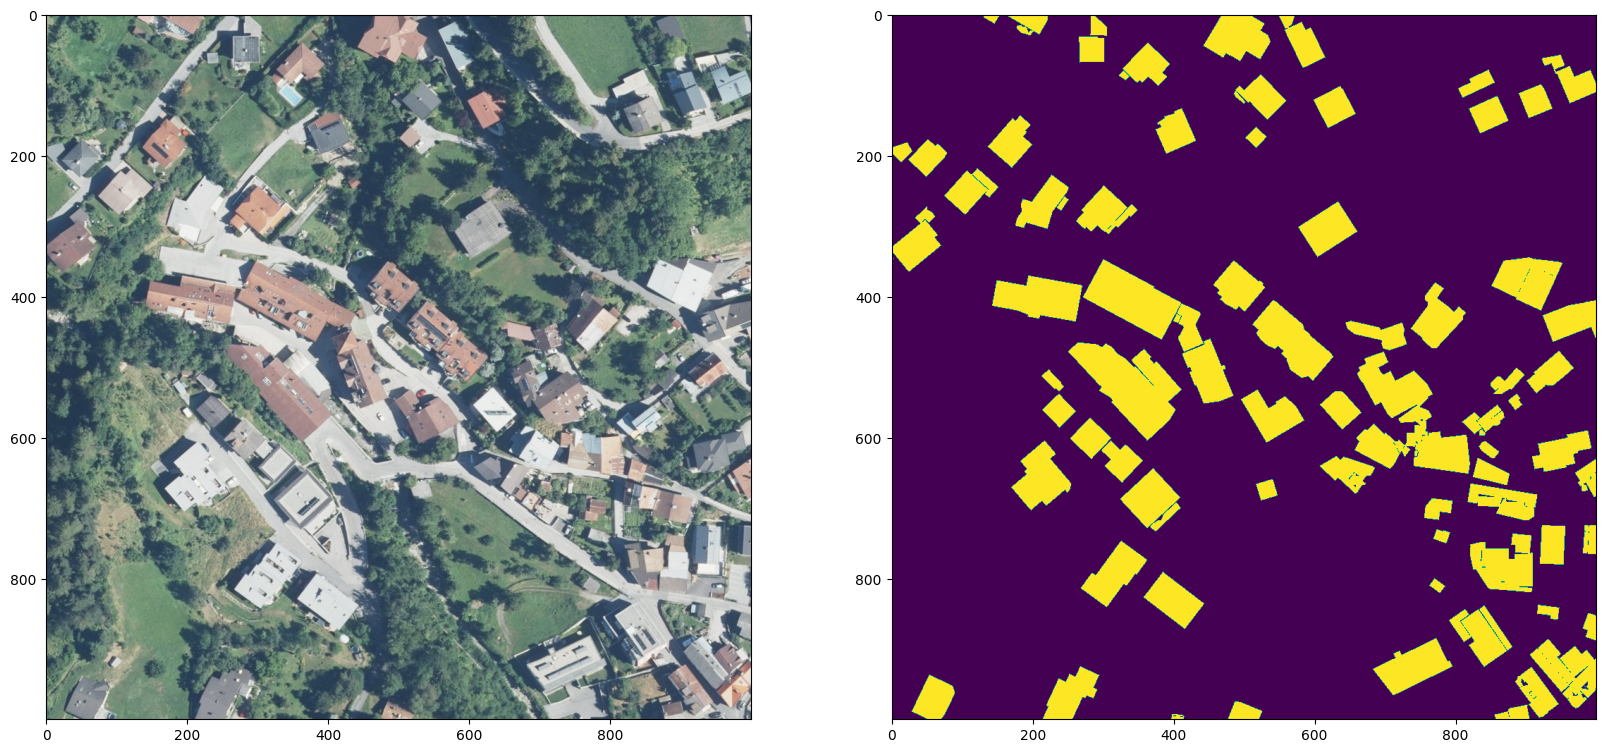

In [ ]:
image = Image.open(os.path.join(ROOT_DIR, 'Processed Images INRIA/13.tif'))
mask = Image.open(os.path.join(ROOT_DIR, 'Processed Masks INRIA/13.tif')).convert('L')

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(image)
axs[1].imshow(mask)
plt.show()

In [ ]:
# prepare the image for the model (aligned resize)
feature_extractor_inference = SegformerImageProcessor(do_random_crop=False, do_pad=False)

pixel_values = feature_extractor_inference(image, return_tensors="pt").pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 512, 512])


In [ ]:
model.eval()

outputs = model(pixel_values=pixel_values) # logits are of shape (batch_size, num_labels, height/4, width/4)
logits = outputs.logits.cpu()
print(logits.shape)

torch.Size([1, 2, 128, 128])


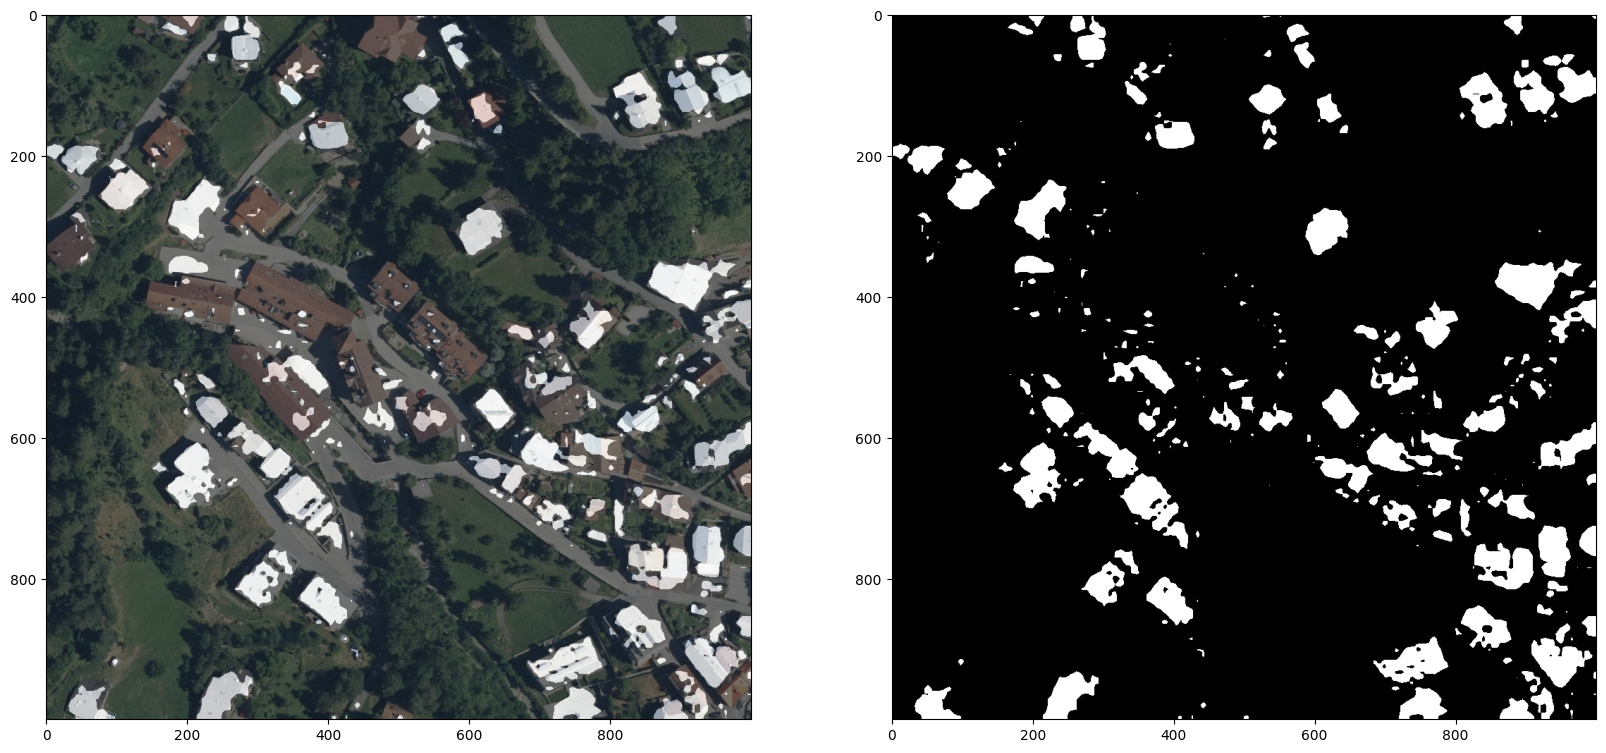

In [ ]:
# First, rescale logits to original image size
upsampled_logits = nn.functional.interpolate(logits,
                size=image.size[::-1], # (height, width)
                mode='bilinear',
                align_corners=False)

# Second, apply argmax on the class dimension
seg = upsampled_logits.argmax(dim=1)[0]
color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3\
for label, color in enumerate(palette*255):
    color_seg[seg == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(img)
axs[1].imshow(color_seg)
plt.show()

### Ejemplo 2

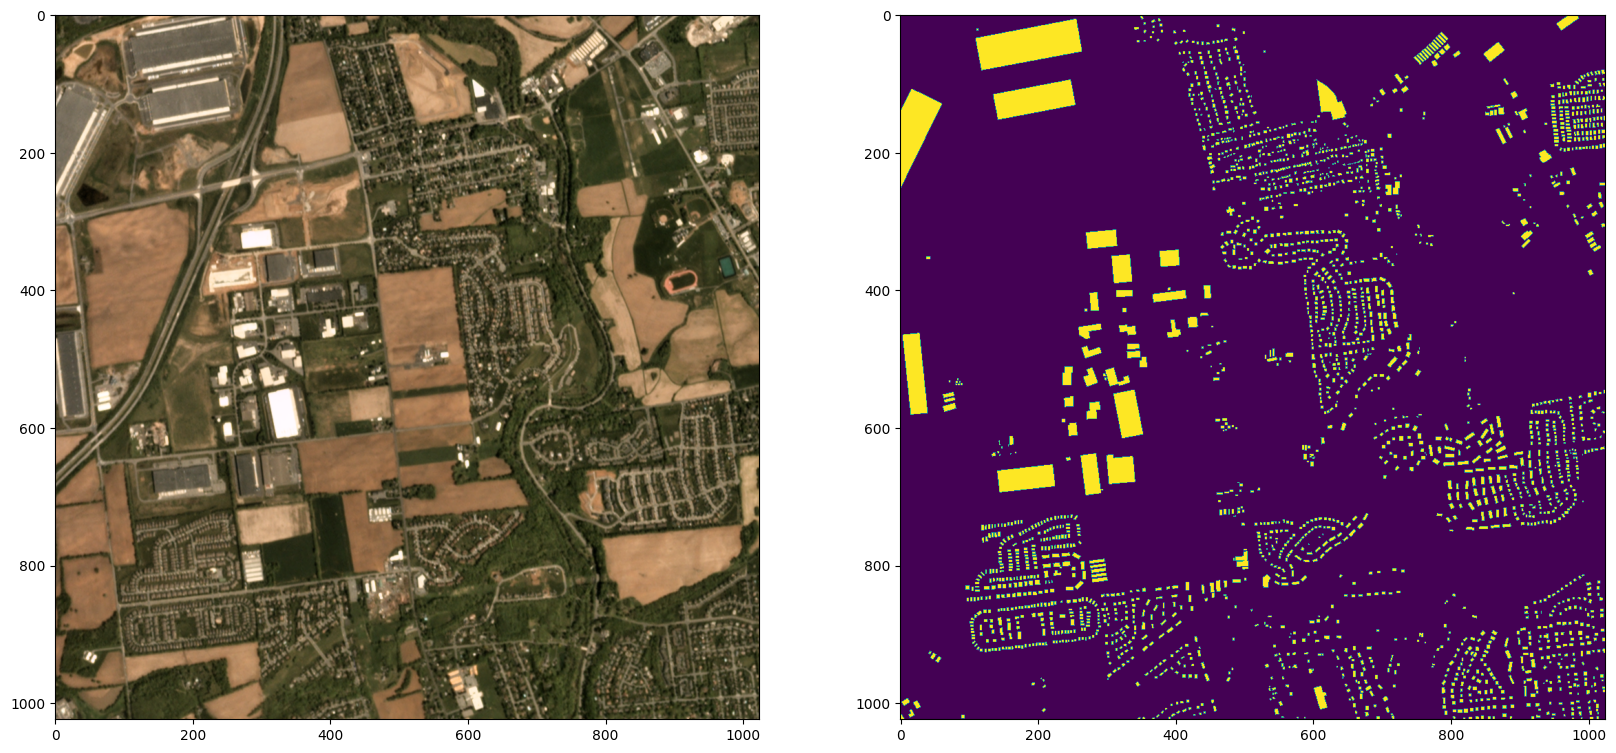

In [ ]:
image = Image.open(os.path.join(IMAGES_DIR, '2986.tif'))
mask = Image.open(os.path.join(MASKS_DIR, '2986.tif')).convert('L')

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(image)
axs[1].imshow(mask)
plt.show()

In [ ]:
# prepare the image for the model (aligned resize)
feature_extractor_inference = SegformerImageProcessor(do_random_crop=False, do_pad=False)

pixel_values = feature_extractor_inference(image, return_tensors="pt").pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 512, 512])


In [ ]:
model.eval()

outputs = model(pixel_values=pixel_values) # logits are of shape (batch_size, num_labels, height/4, width/4)
logits = outputs.logits.cpu()
print(logits.shape)

torch.Size([1, 2, 128, 128])


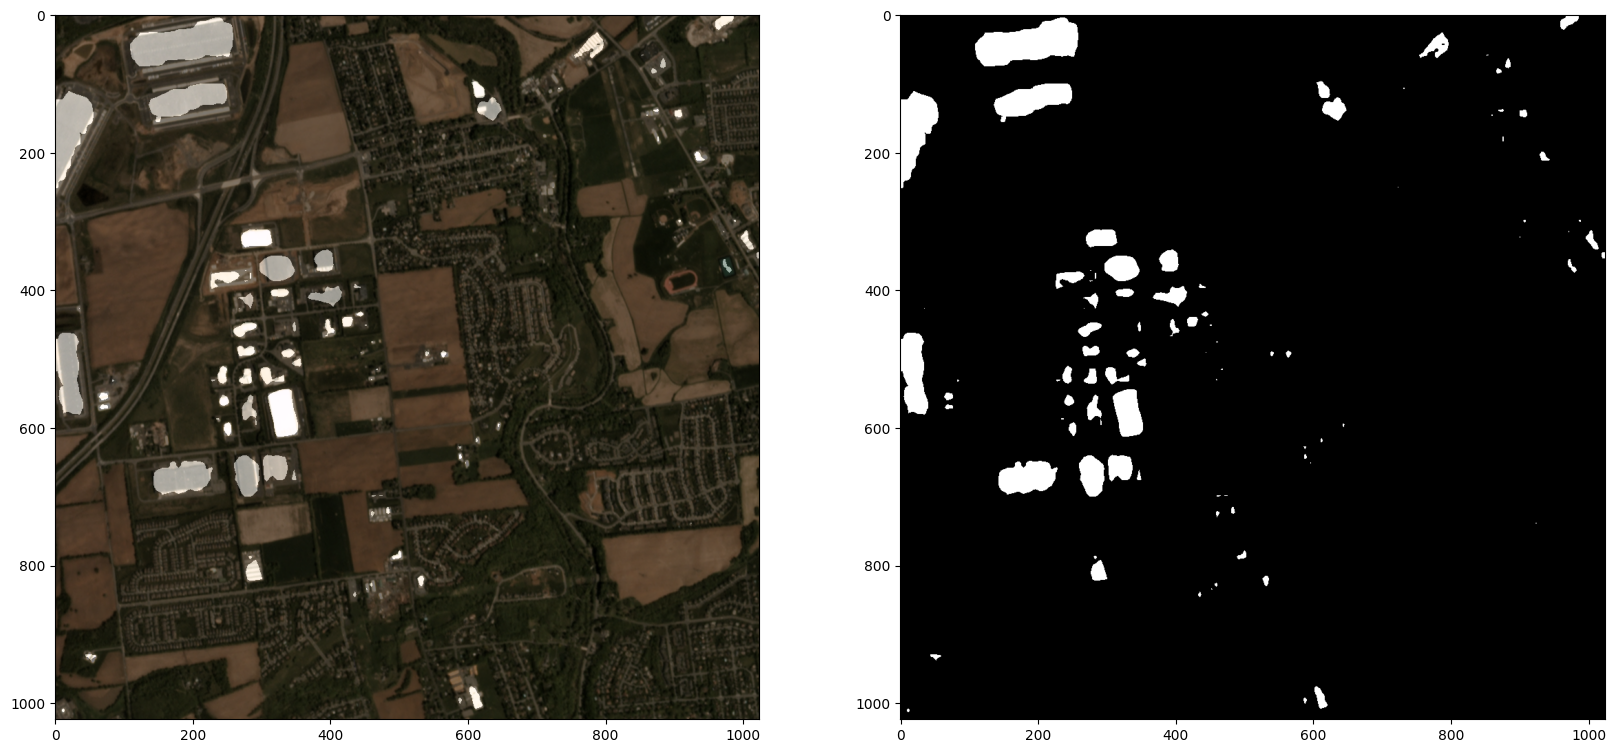

In [ ]:
# First, rescale logits to original image size
upsampled_logits = nn.functional.interpolate(logits,
                size=image.size[::-1], # (height, width)
                mode='bilinear',
                align_corners=False)

# Second, apply argmax on the class dimension
seg = upsampled_logits.argmax(dim=1)[0]
color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3\
for label, color in enumerate(palette*255):
    color_seg[seg == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(img)
axs[1].imshow(color_seg)
plt.show()

## Entrenamiento Spacenet

In [5]:
# Establezco una ruta absoluta a un directorio existente de mi Google Drive
DRIVE_DIR = "/content/drive/MyDrive/TFM/dataset/"

AUX_DIR = "/content"
ROOT_DIR = "/content/dataset"

# Conectamos con nuestro Google Drive
drive.mount('/content/drive')

IMAGES_DIR = os.path.join(ROOT_DIR, 'Processed Images Spacenet')
MASKS_DIR = os.path.join(ROOT_DIR, 'Processed Masks Spacenet')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Descarga del dataset
import shutil

# Copiar todo el contenido de la carpeta de Drive a la carpeta local
shutil.copytree(os.path.join(DRIVE_DIR, "Processed Images Spacenet"), IMAGES_DIR)
shutil.copytree(os.path.join(DRIVE_DIR, "Processed Masks Spacenet"), MASKS_DIR)

'/content/dataset/Processed Masks Spacenet'

In [6]:
# División de los datos en entrenamiento, validación y prueba
images = sorted(os.listdir(IMAGES_DIR))
masks = sorted(os.listdir(MASKS_DIR))
train_images, test_images, train_masks, test_masks = train_test_split(images, masks, test_size=0.2, random_state=42)
train_images, val_images, train_masks, val_masks = train_test_split(train_images, train_masks, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

# Dataset y DataLoader
train_dataset = ImageSegmentationDataset(img_dir=IMAGES_DIR, mask_dir=MASKS_DIR, images=train_images, masks=train_masks, transform=None) #transform=augmentation_transforms)
val_dataset = ImageSegmentationDataset(img_dir=IMAGES_DIR, mask_dir=MASKS_DIR, images=val_images, masks=val_masks, transform=None) #transform=augmentation_transforms)
test_dataset = ImageSegmentationDataset(img_dir=IMAGES_DIR, mask_dir=MASKS_DIR, images=test_images, masks=test_masks, transform=None) #transform=augmentation_transforms)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=0)

In [7]:
sample_img, sample_mask = train_dataset[0]
print(sample_img.shape)
print(sample_mask.shape)

torch.Size([3, 512, 512])
torch.Size([1, 512, 512])


In [8]:
sample_batch = next(iter(train_loader))
images_batch, masks_batch = sample_batch
print(images_batch.shape)
print(masks_batch.shape)

torch.Size([4, 3, 512, 512])
torch.Size([4, 1, 512, 512])


In [9]:
# Modelo
model = models.segmentation.deeplabv3_resnet101(pretrained=True, progress=True)
model.classifier[4] = nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))

# Loss y optimizador
criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.0001)
optimizer = optim.Adam(model.parameters(), lr=0.00005)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [10]:
# Entrenamiento
num_epochs = 8
best_loss = float("inf")

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)["out"]
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Validación
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)["out"]
            loss = criterion(outputs, masks)
            val_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}")

    # Guardar el mejor modelo
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_val_loss,
        }, os.path.join(AUX_DIR, f'best_model_DeepLabV3Plus_2_{epoch}.pth'))

print("Entrenamiento finalizado.")

Epoch 1/8, Train Loss: 0.4660105305542878, Validation Loss: 0.3313071461210788
Epoch 2/8, Train Loss: 0.3047493469517378, Validation Loss: 0.3026257942260151
Epoch 3/8, Train Loss: 0.25068162572327385, Validation Loss: 0.23506202202447704
Epoch 4/8, Train Loss: 0.21850060399674692, Validation Loss: 0.21998910375044378
Epoch 5/8, Train Loss: 0.2018586507340743, Validation Loss: 0.3065351372663404
Epoch 6/8, Train Loss: 0.18919746839039697, Validation Loss: 0.6708270583144376
Epoch 7/8, Train Loss: 0.1848667810242888, Validation Loss: 0.18529908275100546
Epoch 8/8, Train Loss: 0.17940372006164343, Validation Loss: 0.17986950078900432
Entrenamiento finalizado.


## Evaluación - dataset Spacenet

In [11]:
from sklearn.metrics import f1_score, accuracy_score, jaccard_score

In [12]:
# Establezco una ruta absoluta a un directorio existente de mi Google Drive
ROOT_DIR = "/content/drive/MyDrive/TFM/dataset/"
AUX_DIR = "/content/drive/MyDrive/TFM/auxiliar"

# Conectamos con nuestro Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
# 1. Carga los pesos del modelo
CHECKPOINT_PATH = os.path.join(AUX_DIR, 'best_model_DeepLabV3Plus_2_7.pth') # Actualiza con el nombre del archivo correcto
checkpoint = torch.load(CHECKPOINT_PATH)
model.load_state_dict(checkpoint['model_state_dict'])

# 2. Coloca el modelo en modo de evaluación
model.eval()

def calculate_metrics(model, criterion, test_loader, device):
    total_accuracy = 0
    total_f1 = 0
    total_iou = 0
    test_loss = 0
    total_samples = 0

    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)

            # Obtiene las predicciones del modelo
            outputs = model(images)["out"]

            # Calcula la pérdida
            loss = criterion(outputs, masks)
            test_loss += loss.item()

            # Obtiene las etiquetas binarias predichas (0 o 1)
            preds = torch.sigmoid(outputs).data.cpu().numpy() > 0.5
            true_labels = masks.data.cpu().numpy() > 0.5

            # Actualizar las métricas para este batch
            total_accuracy += accuracy_score(true_labels.flatten(), preds.flatten())
            total_f1 += f1_score(true_labels.flatten(), preds.flatten())
            total_iou += jaccard_score(true_labels.flatten(), preds.flatten())
            total_samples += 1

    # Calcular métricas promedio
    avg_test_loss = test_loss / total_samples
    avg_accuracy = total_accuracy / total_samples
    avg_f1 = total_f1 / total_samples
    avg_iou = total_iou / total_samples

    return avg_test_loss, avg_accuracy, avg_f1, avg_iou

# Ejemplo de uso
avg_test_loss, acc, f1, iou = calculate_metrics(model, criterion, test_loader, device)
print(f"Average Test Loss: {avg_test_loss}")
print(f"Accuracy: {acc}")
print(f"F1 Score: {f1}")
print(f"IoU (Jaccard Score): {iou}")

Average Test Loss: 0.1894178138652318
Accuracy: 0.9343454065457196
F1 Score: 0.19454951844545862
IoU (Jaccard Score): 0.11346058188896485


### Ejemplo 1

In [ ]:
image = Image.open(os.path.join(ROOT_DIR, 'Processed Images INRIA/13.tif'))
mask = Image.open(os.path.join(ROOT_DIR, 'Processed Masks INRIA/13.tif')).convert('L')

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(image)
axs[1].imshow(mask)
plt.show()

In [ ]:
# prepare the image for the model (aligned resize)
feature_extractor_inference = SegformerImageProcessor(do_random_crop=False, do_pad=False)

pixel_values = feature_extractor_inference(image, return_tensors="pt").pixel_values.to(device)
print(pixel_values.shape)

In [ ]:
model.eval()

outputs = model(pixel_values=pixel_values) # logits are of shape (batch_size, num_labels, height/4, width/4)
logits = outputs.logits.cpu()
print(logits.shape)

In [ ]:
# First, rescale logits to original image size
upsampled_logits = nn.functional.interpolate(logits,
                size=image.size[::-1], # (height, width)
                mode='bilinear',
                align_corners=False)

# Second, apply argmax on the class dimension
seg = upsampled_logits.argmax(dim=1)[0]
color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3\
for label, color in enumerate(palette*255):
    color_seg[seg == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(img)
axs[1].imshow(color_seg)
plt.show()

### Ejemplo 2

In [ ]:
image = Image.open(os.path.join(IMAGES_DIR, '2986.tif'))
mask = Image.open(os.path.join(MASKS_DIR, '2986.tif')).convert('L')

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(image)
axs[1].imshow(mask)
plt.show()

In [ ]:
# prepare the image for the model (aligned resize)
feature_extractor_inference = SegformerImageProcessor(do_random_crop=False, do_pad=False)

pixel_values = feature_extractor_inference(image, return_tensors="pt").pixel_values.to(device)
print(pixel_values.shape)

In [ ]:
model.eval()

outputs = model(pixel_values=pixel_values) # logits are of shape (batch_size, num_labels, height/4, width/4)
logits = outputs.logits.cpu()
print(logits.shape)

In [ ]:
# First, rescale logits to original image size
upsampled_logits = nn.functional.interpolate(logits,
                size=image.size[::-1], # (height, width)
                mode='bilinear',
                align_corners=False)

# Second, apply argmax on the class dimension
seg = upsampled_logits.argmax(dim=1)[0]
color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3\
for label, color in enumerate(palette*255):
    color_seg[seg == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(img)
axs[1].imshow(color_seg)
plt.show()

## CONCLUSIONES

1. <b>Dataset INRIA:</b>
- Pérdida promedio en test: 0.12457748923657669
- Accuracy promedio en test: <b>0.9515579689873589</b>
- IoU promedio en test: 0.7271778584001464
- F1 Score promedio en test: 0.8396381000145476

2. <b>Dataset Spacenet:</b>
- Pérdida promedio en test: 0.1894178138652318
- Accuracy promedio en test: <b>0.9343454065457196</b>
- IoU promedio en test: 0.11346058188896485
- F1 Score promedio en test: 0.19454951844545862
